## Fruit 360 Classification

Data source: https://www.kaggle.com/datasets/moltean/fruits

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os
import pathlib
from zipfile import ZipFile
import PIL

import tensorflow as tf

2025-03-27 16:07:01.910894: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_dir = pathlib.Path("Training")
# test_dir = pathlib.Path("fruits-360-original-size/Training")

In [3]:
image_count = len(list(train_dir.glob("*/*.jpg")))
image_count

1318

### Visulization

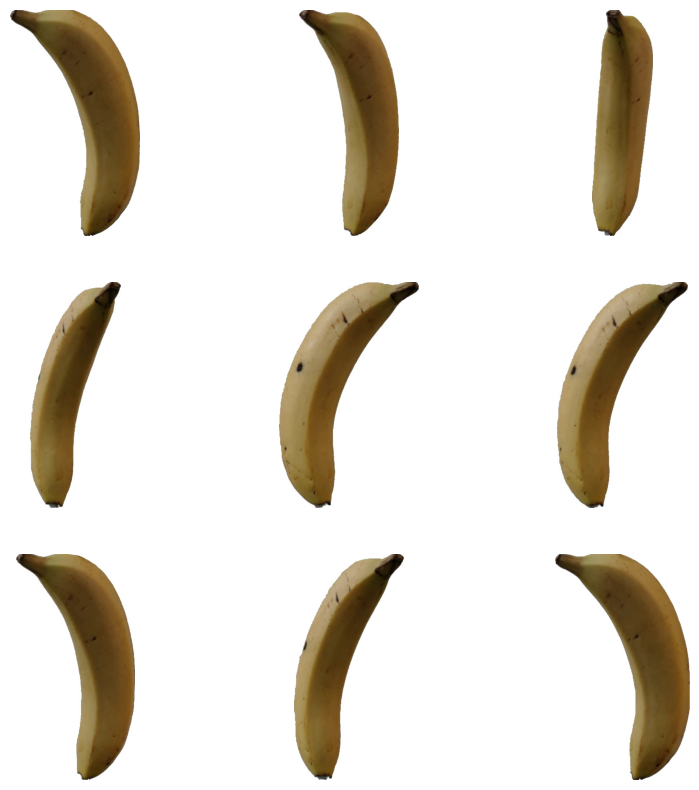

In [4]:
fruits = list(train_dir.glob('Banana 3/*.jpg'))

plt.figure(figsize=(10,10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = PIL.Image.open(str(fruits[i]))
    plt.imshow(img)
    plt.axis("off")

plt.show()

In [5]:
batch_size = 32
img_height = 100
img_width = 100

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 1318 files belonging to 18 classes.
Using 1055 files for training.
Found 1318 files belonging to 18 classes.
Using 263 files for validation.


2025-03-27 16:07:09.989864: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
class_names = train_ds.class_names
num_class = len(class_names)

2025-03-27 16:07:12.984086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1055]
	 [[{{node Placeholder/_0}}]]
2025-03-27 16:07:12.985122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1055]
	 [[{{node Placeholder/_0}}]]


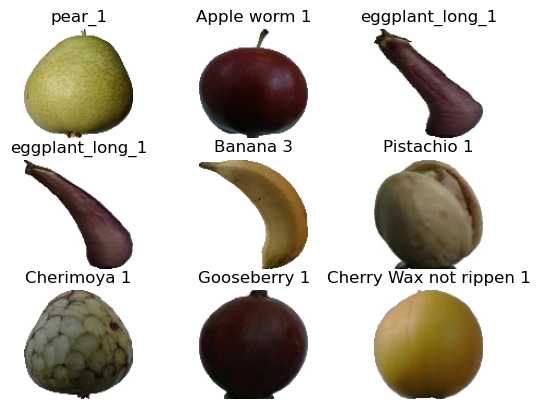

In [8]:
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

### Preprocessing/Setting up Base Model

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [12]:
base_model = tf.keras.applications.resnet.ResNet50(
    input_shape=(img_height, img_width, 3),
    include_top = False,
    weights = 'imagenet'
)

In [13]:
base_model.trainable = False

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_class)

### Building the Model

In [15]:
inputs = tf.keras.Input(shape=(100, 100, 3))
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 100, 100, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 100, 100, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0     

### Training the Model

In [18]:
model.evaluate(val_ds)

2025-03-27 16:07:38.877614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [263]
	 [[{{node Placeholder/_0}}]]
2025-03-27 16:07:38.879218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [263]
	 [[{{node Placeholder/_0}}]]


9/9 [==============================] - 49s 5s/step - loss: 4.2390 - accuracy: 0.0570


[4.239039421081543, 0.057034220546483994]

In [19]:
epochs = 10

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data = val_ds
)

Epoch 1/10


2025-03-27 16:09:06.893887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1055]
	 [[{{node Placeholder/_4}}]]
2025-03-27 16:09:06.895211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1055]
	 [[{{node Placeholder/_0}}]]


33/33 [==============================] - 242s 7s/step - loss: 3.2520 - accuracy: 0.1545 - val_loss: 1.9340 - val_accuracy: 0.3726
Epoch 2/10
33/33 [==============================] - 275s 8s/step - loss: 1.5300 - accuracy: 0.5147 - val_loss: 0.8273 - val_accuracy: 0.8935
Epoch 3/10
33/33 [==============================] - 272s 8s/step - loss: 0.7559 - accuracy: 0.8076 - val_loss: 0.3779 - val_accuracy: 0.9696
Epoch 4/10
33/33 [==============================] - 271s 8s/step - loss: 0.3993 - accuracy: 0.9299 - val_loss: 0.2016 - val_accuracy: 0.9810
Epoch 5/10
33/33 [==============================] - 272s 8s/step - loss: 0.2238 - accuracy: 0.9791 - val_loss: 0.1295 - val_accuracy: 1.0000
Epoch 6/10
33/33 [==============================] - 273s 8s/step - loss: 0.1662 - accuracy: 0.9867 - val_loss: 0.0891 - val_accuracy: 1.0000
Epoch 7/10
33/33 [==============================] - 238s 7s/step - loss: 0.1188 - accuracy: 0.9972 - val_loss: 0.0668 - val_accuracy: 1.0000
Epoch 8/10
33/33 [======

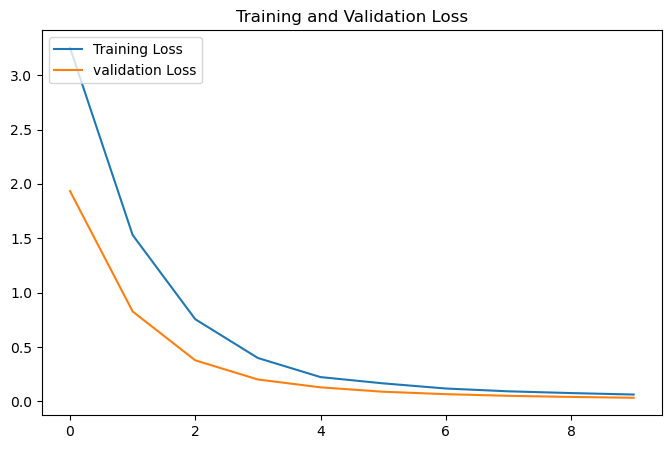

In [22]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='validation Loss')
plt.legend(loc='upper left')
plt.title("Training and Validation Loss")

plt.show()

In [24]:
np.argmin(val_loss)

9